<a href="https://colab.research.google.com/github/senthilv83/Data-Science-Challenges/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! pip install langdetect
# ! pip install translate
# ! pip install gensim
# ! python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 8.5 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=b8eb73ae5e1f85043d1baec0b2f2f4cc7a26865fd4ff6e0112fb72e625e3478d
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-09-26 07:52:15.692307: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.2 kB/s 
✔ Download and installation su

In [ ]:
import spacy.cli
#spacy.cli.download("en_core_web_lg")
import en_core_web_lg
nlp = en_core_web_lg.load()

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for text processing
from dateutil import parser
import string
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from spacy.lang.en.stop_words import STOP_WORDS

from gensim.models import KeyedVectors

## for language detection
## warnings !!
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving jd.CSV - jd.CSV.csv to jd.CSV - jd.CSV.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['jd.CSV - jd.CSV.csv']))

In [ ]:
df.head()

,job_no,job_description,job_type,category
0,Id-17264,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
1,Id-22925,"En el mundo de los CRO's típicos, esta compañí...",Permanent,Clinical Research
2,Id-1321,Asha Mistry of Umbilical Life is recruiting an...,Contract/Interim,Pharmaceutical Marketing
3,Id-9473,Sales Representative - Laser in der Medizinte...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
4,Id-14952,Field Service Engineer - Life Science\n\n\nCam...,Permanent,Manufacturing & Operations


In [ ]:
df = df.dropna()
df.info()
df = df.head(5000)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17657 entries, 0 to 17656
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_no           17657 non-null  object
 1   job_description  17657 non-null  object
 2   job_type         17657 non-null  object
 3   category         17657 non-null  object
dtypes: object(4)
memory usage: 689.7+ KB


In [ ]:
from sklearn.model_selection import train_test_split

y = df['category']
X = df[['job_no','job_description','job_type']]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42, stratify=y)

train = pd.concat([X_train,y_train], axis=1)

test = pd.concat([X_test,y_test], axis=1)

In [ ]:
train.head() # we have 6 classes in 'job_type' and 11 classes in  'category'

,job_no,job_description,job_type,category
3774,Id-881,A great opportunity for a life science-based g...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
666,Id-5415,PhD Holder? Medical Writer - Boston\n\n\nMy c...,Permanent,Regulatory Affairs
2526,Id-23266,Gerente de Cuentas Senior - Imágenes Quirúrgic...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"
118,Id-15040,Quality Control Technologist - Hertfordshire ...,Permanent,Quality-assurance
4909,Id-18278,I am recruiting for several SCRAs / Senior Cli...,Permanent,Science


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 4416 to 3064
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_no           1000 non-null   object
 1   job_description  1000 non-null   object
 2   job_type         1000 non-null   object
 3   category         1000 non-null   object
dtypes: object(4)
memory usage: 39.1+ KB


In [ ]:
train.isnull().sum() # Verifying if needs any null modification !!

job_no             0
job_description    0
job_type           0
category           0
dtype: int64

In [ ]:
train['job_description'][0]

" Zest Scientific is searching for an accomplished Scientific Sales professional in the Netherlands. This territory will play a pivotal role as the company increases their presence across Europe, presenting a wealth of untapped potential. Our client is internationally recognized for providing 'best in class' solutions. This region provides excellent growth opportunities for a motivated and entrepreneurial Technical Sales Specialist. This is a highly autonomous role where your input will be encouraged and you will be provided with the platform in which to implement your own selling methods / business plan.\n\n\nThe Candidate:\n\n\n * You will demonstrate a successful track record selling into academic research, clinical diagnostics / hospital laboratories or biotech accounts.\n\n\n * Ability to learn new scientific concepts as you will be required to take a 'hands on' approach supporting customers at all stages of the sales process.\n\n\n * Independent and comfortable working with limit

Class counts for Job_type : 
 Permanent             3562
Contract/Interim       330
Contract/Temp           64
Temporary/Seasonal      35
Part-Time                5
Any                      4
Name: job_type, dtype: int64


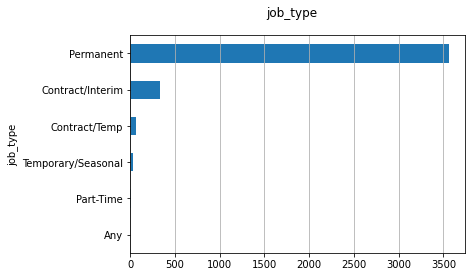

In [ ]:
print('Class counts for Job_type : \n',train['job_type'].value_counts())

fig, ax = plt.subplots()
fig.suptitle('job_type', fontsize=12)
train['job_type'].reset_index().groupby('job_type').count().sort_values(by=
       "index").plot(kind="barh", legend=False,
        ax=ax).grid(axis='x')
plt.show()


Class counts for category : 
 Pharmaceutical, Healthcare and Medical Sales    1021
Clinical Research                                727
Science                                          686
Manufacturing & Operations                       486
Pharmaceutical Marketing                         259
Regulatory Affairs                               255
Data Management and Statistics                   183
Quality-assurance                                149
Medical Information and Pharmacovigilance        139
Medical Affairs / Pharmaceutical Physician        88
Pharmacy                                           7
Name: category, dtype: int64


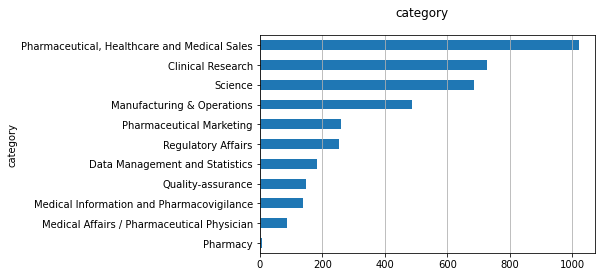

In [ ]:

print('Class counts for category : \n',train['category'].value_counts())

fig, ax = plt.subplots()
fig.suptitle('category', fontsize=12)
train['category'].reset_index().groupby('category').count().sort_values(by=
       "index").plot(kind="barh", legend=False,
        ax=ax).grid(axis='x')
plt.show()

In [ ]:
# Lets focus on job description !!!

# Steps to be taken :
#
#     1. Text pre-processing:
#         1.1 Normalize case
#         1.2 Special character
#         1.3 Stop words
#         1.4 White space
#         1.5 Stemming

#     2. Feature extraction:
#         2.1 Word2vec embedding

In [ ]:
# Cleaning Process:

# For dates removal ~

def is_valid_date(date_str): # sub function
    try:
        parser.parse(date_str)
        return True
    except:
        return False

def date_removal(data):
    new_list = [' '.join([w for w in line.split() if not is_valid_date(w)]) for line in data]
    return (new_list[0])

def stemmer_and_stopWord(doc):

    doc= nlp(doc)
    token_list = []
    for token in doc:
      lemma = token.lemma_
      if lemma == '-PRON-' or lemma == 'be':
        lemma = token.text
      token_list.append(lemma)

    stemmed = token_list

    # Create list of word tokens after removing stopwords

    filtered_sentence =[]
    for word in stemmed[:100]:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word)
    return (' '.join(filtered_sentence))

def normaliz(filtered_sentence):

    words = [str(word).lower() for word in filtered_sentence.split()]
    return  ' '.join(words[:100])

# For number removal ~

def numbers_removal(data):
    s = [data]
    result = ''.join([i for i in s if not i.isdigit()])
    return (result)
# For punchuation & double white spaces ~

def punch_removal(words):
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in [words]]
    return re.sub(' +', ' ', stripped[:100][0])


def cleaner(data):
    string = [data]
    string = date_removal(string)
    # string = numbers_removal(string)
    string = punch_removal(string)
    string = stemmer_and_stopWord(string)
    string = normaliz(string)
    return string

In [ ]:
def cleaner(data):
    string = [data]
    string = date_removal(string)
    # string = numbers_removal(string)
    string = punch_removal(string)
    string = stemmer_and_stopWord(string)
    string = normaliz(string)
    return string

print('* --------------- for train data --------------- *')

list=[]
for i in train['job_description']: # cleansing !!
    list.append(cleaner(i))

train['job_description']=pd.Series(list) # updating the attributee !!

print('* --------------- for test data --------------- *')

list=[]
for i in test['job_description']: # cleansing !!
    list.append(cleaner(i))

test['job_description']=pd.Series(list) # updating the attributee !!


* --------------- for train data --------------- *
* --------------- for test data --------------- *


In [ ]:
## Feature extarction or EDA :

In [ ]:
train = train.dropna()
test = test.dropna()

* ------------------------- for train data-------------------------------- *


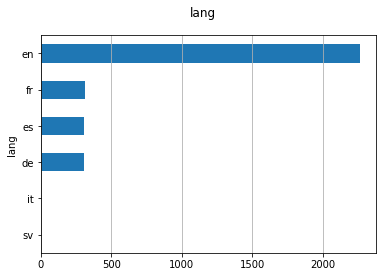

* -------------------------- for test data ------------------------------- *


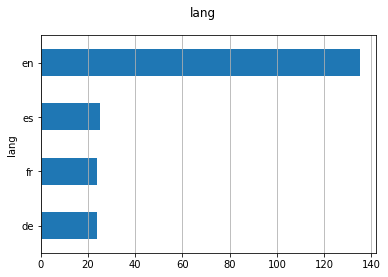

In [ ]:
# adding a new attribute for differencing the language of teh 'job_description' !!

import langdetect

print('* ------------------------- for train data-------------------------------- *')

train['lang'] = train["job_description"].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")

fig, ax = plt.subplots()
fig.suptitle('lang', fontsize=12)
train['lang'].reset_index().groupby('lang').count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

print('* -------------------------- for test data ------------------------------- *')

test['lang'] = test["job_description"].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")

fig, ax = plt.subplots()
fig.suptitle('lang', fontsize=12)
test['lang'].reset_index().groupby('lang').count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()


In [ ]:
train.reset_index(inplace = True)
test.reset_index(inplace = True)

In [ ]:
train.drop('index',axis = 1, inplace=True)
test.drop('index',axis = 1, inplace=True)
train.head()


,job_no,job_description,job_type,category,lang
0,Id-881,exciting challenging opportunity arise product...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en
1,Id-5415,ck group recruit clinical process analyst join...,Permanent,Regulatory Affairs,en
2,Id-23266,key account manager northern scotland carence ...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",fr
3,Id-15040,área de terapia cardiovascular paquete salario...,Permanent,Quality-assurance,es
4,Id-3611,austin fraser work lead medical device company...,Permanent,Manufacturing & Operations,en


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3194 entries, 0 to 3193
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_no           3194 non-null   object
 1   job_description  3194 non-null   object
 2   job_type         3194 non-null   object
 3   category         3194 non-null   object
 4   lang             3194 non-null   object
dtypes: object(5)
memory usage: 124.9+ KB


In [ ]:
train[train['job_description'].isnull()].sum()

job_no             0.0
job_description    0.0
job_type           0.0
category           0.0
lang               0.0
dtype: float64

In [ ]:
# Feature Extraction from the job discription :

print('* ------------------------- for train data-------------------------------- *')

# the relevance of these feature will be tested on the later stages !!

train['word_count'] = train["job_description"].apply(lambda x:
                                                     len(str(x).split(" ")))
train['char_count'] = train["job_description"].apply(lambda x:
                                                     sum(len(word)
                                                     for word in str(x).split(" ")))
train['sentence_count'] = train["job_description"].apply(lambda x:
                                                         len(str(x).split(".")))
train['avg_word_length'] = train['char_count'] / train['word_count']
train['avg_sentence_lenght'] = train['word_count'] / train['sentence_count']

print('* ------------------------- for test data-------------------------------- *')

test['word_count'] = test["job_description"].apply(lambda x:
                                                   len(str(x).split(" ")))
test['char_count'] = test["job_description"].apply(lambda x:
                                                   sum(len(word)
                                                   for word in str(x).split(" ")))
test['sentence_count'] = test["job_description"].apply(lambda x:
                                                       len(str(x).split(".")))
test['avg_word_length'] = test['char_count'] / test['word_count']
test['avg_sentence_lenght'] = test['word_count'] / test['sentence_count']


* ------------------------- for train data-------------------------------- *
* ------------------------- for test data-------------------------------- *


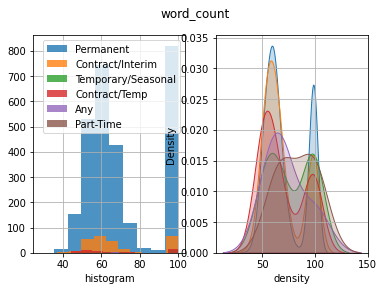

In [ ]:
# A bivariate distributions to look at the correlation of a attribute with the target class !!

# conclusion : The categories have a similar length distribution but the samples have different sizes.

x = 'word_count'
y = 'job_type'

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=12)
for i in train[y].unique():
    sns.distplot(train[train[y]==i][x], hist=True, kde=False,
                 bins=10, hist_kws={"alpha":0.8},
                 axlabel="histogram", ax=ax[0])
    sns.distplot(train[train[y]==i][x], hist=False, kde=True,
                 kde_kws={"shade":True}, axlabel="density",
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(train[y].unique())
ax[1].grid(True)
plt.show()

In [ ]:
train.head()

,job_no,job_description,job_type,category,lang,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,Id-881,exciting challenging opportunity arise product...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",en,60,468,1,7.800000,60.0
1,Id-5415,ck group recruit clinical process analyst join...,Permanent,Regulatory Affairs,en,69,448,1,6.492754,69.0
2,Id-23266,key account manager northern scotland carence ...,Permanent,"Pharmaceutical, Healthcare and Medical Sales",fr,99,542,1,5.474747,99.0
3,Id-15040,área de terapia cardiovascular paquete salario...,Permanent,Quality-assurance,es,99,557,1,5.626263,99.0
4,Id-3611,austin fraser work lead medical device company...,Permanent,Manufacturing & Operations,en,58,400,1,6.896552,58.0


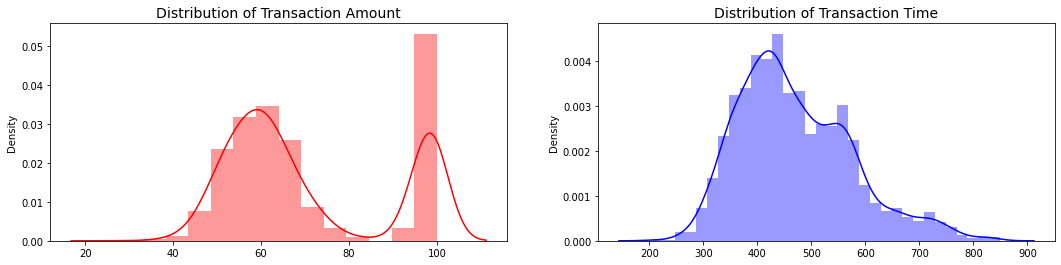

In [ ]:
ig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = train['word_count'].values
time_val = train['char_count'].values

sns.distplot(amount_val, ax=ax[0], color='red')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)

sns.distplot(time_val, ax=ax[1], color='blue')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)

plt.show()

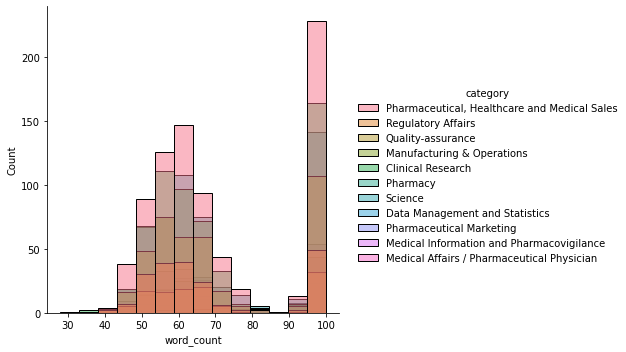

In [ ]:
x = 'word_count'
y = 'job_type'

sns.displot(train, x="word_count", hue="category")

* ------------------------- for train data-------------------------------- *


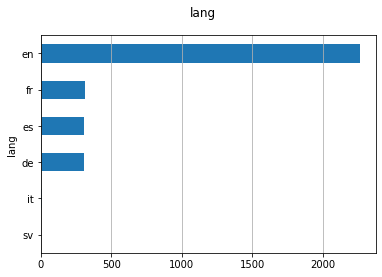

* -------------------------- for test data ------------------------------- *


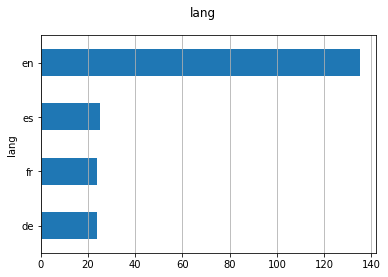

In [ ]:
# adding a new attribute for differencing the language of teh 'job_description' !!

import langdetect

print('* ------------------------- for train data-------------------------------- *')

train['lang'] = train["job_description"].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")

fig, ax = plt.subplots()
fig.suptitle('lang', fontsize=12)
train['lang'].reset_index().groupby('lang').count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()

print('* -------------------------- for test data ------------------------------- *')

test['lang'] = test["job_description"].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")

fig, ax = plt.subplots()
fig.suptitle('lang', fontsize=12)
test['lang'].reset_index().groupby('lang').count().sort_values(by= "index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.show()


Modeling

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam



import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling1D, GlobalMaxPooling1D, LSTM, Dropout, GRU, Activation, Embedding, Bidirectional,SpatialDropout1D, BatchNormalization, Conv1D, MaxPool1D

In [ ]:
MAX_NB_WORDS = 28523 + 1

MAX_SEQUENCE_LENGTH = 100


EMBEDDING_DIM = 100

Job_type = {
    'Permanent':0,
    'Contract/Interim':1,
    'Contract/Temp':2,
    'Temporary/Seasonal':3,
    'Any':4,
    'Part-Time':6
    }

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['job_description'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15436 unique tokens.


In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, oov_token='OOV')

tokenizer.fit_on_texts(train['job_description'].values)
X = tokenizer.texts_to_sequences(train['job_description'].values)

MAX_NB_WORDS = len(tokenizer.word_index) + 1

MAX_SEQUENCE_LENGTH = 100

EMBEDDING_DIM = 100

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH) # Training labels

Y = pd.get_dummies(train.replace
                   ({"job_type": Job_type})
                   ['job_type'].values) # Target class

In [ ]:
X = tokenizer.texts_to_sequences(train['job_description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3194, 100)


Training

In [ ]:
Job_type = {
    'Permanent':0,
    'Contract/Interim':1,
    'Contract/Temp':2,
    'Temporary/Seasonal':3,
    'Any':4,
    'Part-Time':6
    }


Y = pd.get_dummies(train.replace({"job_type": Job_type})['job_type'].values)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3194, 6)


In [ ]:
# Data Splitting
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10,
                                                    random_state = 42)

# Modeling
job_model = Sequential()
job_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))

job_model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
job_model.add(LSTM(80, dropout=0.3, recurrent_dropout=0.3))

job_model.add(Dense(128, activation='relu'))
job_model.add(Dropout(0.3))

job_model.add(Dense(6, activation='softmax'))
job_model.compile(loss='categorical_crossentropy', optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
class_w = {
    0:0.18616874,
    1:2.1041366,
    2:10.1969697,
    3:25.80825959,
    4:116.65333333,
    5:126.79710145
}

In [ ]:
job_model = Sequential()
job_model.add(Embedding(MAX_NB_WORDS, 300, input_length=X.shape[1]))


job_model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

job_model.add(Dense(128, activation='relu'))
job_model.add(Dropout(0.3))

job_model.add(Dense(6, activation='softmax'))
job_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = job_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], class_weight = class_w)

Epoch 1/10
41/41 [==============================] - 24s 520ms/step - loss: 1.8130 - accuracy: 0.3836 - val_loss: 1.7483 - val_accuracy: 0.5417
Epoch 2/10
41/41 [==============================] - 21s 512ms/step - loss: 1.7334 - accuracy: 0.3681 - val_loss: 1.4624 - val_accuracy: 0.8507
Epoch 3/10
41/41 [==============================] - 21s 511ms/step - loss: 1.4304 - accuracy: 0.5491 - val_loss: 1.1198 - val_accuracy: 0.7569
Epoch 4/10
41/41 [==============================] - 21s 505ms/step - loss: 0.8010 - accuracy: 0.6999 - val_loss: 1.1289 - val_accuracy: 0.5382
Epoch 5/10
41/41 [==============================] - 21s 504ms/step - loss: 0.3626 - accuracy: 0.6729 - val_loss: 1.1790 - val_accuracy: 0.4549
Epoch 6/10
41/41 [==============================] - 21s 509ms/step - loss: 0.2420 - accuracy: 0.7916 - val_loss: 1.0516 - val_accuracy: 0.6250
Epoch 7/10
41/41 [==============================] - 21s 509ms/step - loss: 0.2034 - accuracy: 0.8368 - val_loss: 1.1634 - val_accuracy: 0.5556

In [ ]:
accr = job_model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

10/10 [==============================] - 1s 47ms/step - loss: 1.0402 - accuracy: 0.7688
Test set
  Loss: 1.040
  Accuracy: 0.769


10/10 [==============================] - 0s 48ms/step - loss: 1.0402 - accuracy: 0.7688
Test set
  Loss: 1.040
  Accuracy: 0.769


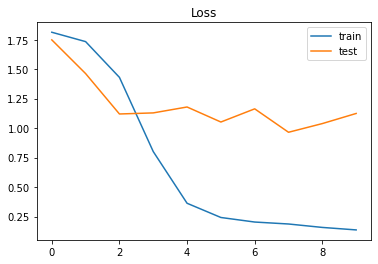

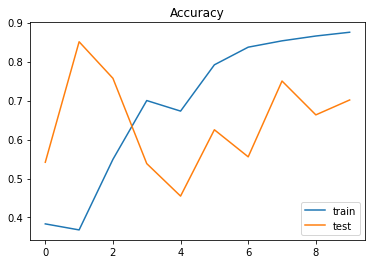

In [ ]:
accr = job_model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Predicting the Type :

In [ ]:
job_pred = []

for i in test['job_description']:
    seq = tokenizer.texts_to_sequences([i])

    padded = pad_sequences(seq, maxlen = MAX_SEQUENCE_LENGTH)
    pred = job_model.predict(padded)
    labels = ['Permanent','Contract/Interim','Contract/Temp','Temporary/Seasonal',
            'Any','Part-Time']
    job_pred.append(labels[np.argmax(pred)])


sub = pd.DataFrame()
sub['job_no'] = test['job_no']
sub['job_type']=pd.Series(job_pred)


In [ ]:
sub.head()

,job_no,job_type
0,Id-19663,Permanent
1,Id-18900,Permanent
2,Id-5576,Permanent
3,Id-8779,Permanent
4,Id-1330,Contract/Interim
